https://github.com/modflowpy/flopy/blob/develop/examples/Tutorials/Tutorial02/tutorial02.py

In [154]:
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy
%matplotlib inline


In [155]:
#Set working directory and names
ws = 'C:/Users/Admin/Desktop/Chelsea/Projects/DelawareStream/FloPy/Tutorial02'
wspath = 'C:/Users/Admin/Desktop/Chelsea/Projects/DelawareStream/FloPy/Tutorial02/'
if not os.path.exists(ws): #make sure workspace directory exists
    os.makedirs(ws)
name = 'Tutorial02'
modelname = 'Tutorial02'
exe_name = os.path.abspath('C:/Users/Admin/Desktop/Chelsea/Projects/DelawareStream/Script/Executables/mf2005')

In [163]:
# Model domain and grid definition
Lx = 1000. #total width across rows of entire model
Ly = 1000. #total width across columns
ztop = 10. #top elevation of layer 1
zbot = -50. #bottom elevation
nlay = 1 #number of layers
nrow = 10 #number of rows
ncol = 10 #number of columns
delr = Lx / ncol #the cell width along rows
delc = Ly / nrow #the cell width along columns
delv = (ztop - zbot) / nlay #elevation change from top to bottom of model
botm = np.linspace(ztop, zbot, nlay + 1) # bottom elevation of each layer including top elevation 
hk = 1. #hydraulic conductivity along rows
vka = 1. #vertical hydraulic conductivity
sy = 0.1 #specific yield
ss = 1.e-4 #specific storage
laytyp = 1 #layer type, 0 - confined, >0 - convertible, <0 - convertialbe unless THICKSTRT

In [168]:
# Variables for the BAS package, which is used to specify (1) the location of active, inactive, and specified head cells, 
# (2) the head stored in inactive cells, and (3) the initial heads in all cells.

# Note that changes from the previous tutorial!
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #boundary variable... one value for every cell... if >0 cell is active, if =0 cell is inactive, if <0 cell has constant head. 
strt = 10. * np.ones((nlay, nrow, ncol), dtype=np.float32) #initial starting head... one value for every cell

In [169]:
# Time step parameters
nper = 3 #number of stress periods
perlen = [1, 100, 100] #length of stress period
nstp = [1, 100, 100] #number of time steps in each stress period
steady = [True, False, False] #transient or steady state

In [170]:
# FloPy objects
mf = flopy.modflow.Modflow(modelname=name, model_ws=ws, exe_name=exe_name)
# Creates Discretization File, which gives (1) the number of rows, columns and layers, (2) the cell sizes, 
# (3) the presence of Quasi-3D confining beds, and (4) the time discretization.
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc, 
                               top=ztop, botm=botm[1:], #ony takes the bottom... excludes the top elevation
                               nper=nper, perlen=perlen, nstp=nstp,
                               steady=steady)
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
# The Layer-Property Flow package is used to specify properties controlling flow between cells.
# Ipakcb - A flag that is used to determine if cell-by-cell budget data should be saved. If ipakcb is non-zero cell-by-cell 
# budget data will be saved. (default is 53)
lpf = flopy.modflow.ModflowLpf(mf, hk=hk, vka=vka, sy=sy, ss=ss, laytyp=laytyp, 
                               ipakcb=53) 
# The Preconditioned Conjugate-Gradient package is used to solve the finite difference 
# equations in each step of a MODFLOW stress period.
pcg = flopy.modflow.ModflowPcg(mf) 

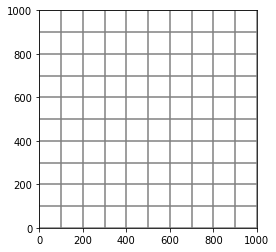

In [174]:
mm = flopy.plot.PlotMapView(model=mf)
plota = mm.plot_grid()

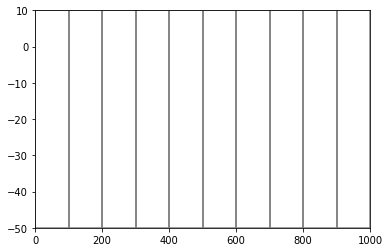

In [175]:
mm2 = flopy.plot.PlotCrossSection(model=mf, line={'row': 2})
plotb = mm2.plot_grid()

In [140]:
# Make list for stress period 1
stageleft = 10.
stageright = 10.
bound_sp1 = []
for il in range(nlay):
    condleft = hk * (stageleft - zbot) * delc
    condright = hk * (stageright - zbot) * delc
    for ir in range(nrow):
        bound_sp1.append([il, ir, 0, stageleft, condleft])
        bound_sp1.append([il, ir, ncol - 1, stageright, condright])
print('Adding ', len(bound_sp1), 'GHBs for stress period 1.')

Adding  100 GHBs for stress period 1.


In [141]:
# Make list for stress period 2
stageleft = 10.
stageright = 0.
condleft = hk * (stageleft - zbot) * delc
condright = hk * (stageright - zbot) * delc
bound_sp2 = []
for il in range(nlay):
    for ir in range(nrow):
        bound_sp2.append([il, ir, 0, stageleft, condleft])
        bound_sp2.append([il, ir, ncol - 1, stageright, condright])
print('Adding ', len(bound_sp2), 'GHBs for stress period 2.')

Adding  100 GHBs for stress period 2.


In [142]:
# We do not need to add a dictionary entry for stress period 3.
# Flopy will automatically take the list from stress period 2 and apply it
# to the end of the simulation
stress_period_data = {0: bound_sp1, 1: bound_sp2}

In [143]:
# Create the flopy ghb object
ghb = flopy.modflow.ModflowGhb(mf, stress_period_data=stress_period_data)

In [144]:
# Create the well package
# Remember to use zero-based layer, row, column indices!
pumping_rate = -500.
wel_sp1 = [[0, nrow/2 - 1, ncol/2 - 1, 0.]]
wel_sp2 = [[0, nrow/2 - 1, ncol/2 - 1, 0.]]
wel_sp3 = [[0, nrow/2 - 1, ncol/2 - 1, pumping_rate]]
stress_period_data = {0: wel_sp1, 1: wel_sp2, 2: wel_sp3}
wel = flopy.modflow.ModflowWel(mf, stress_period_data=stress_period_data)

In [145]:
# Output control
stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        stress_period_data[(kper, kstp)] = ['save head',
                                            'save drawdown',
                                            'save budget',
                                            'print head',
                                            'print budget']
oc = flopy.modflow.ModflowOc(mf, stress_period_data=stress_period_data,
                             compact=True)


In [146]:
# Write the model input files
mf.write_input()

In [147]:
# Run the model
success, mfoutput = mf.run_model(silent=False, pause=False)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: C:\Users\Admin\Desktop\Chelsea\Projects\DelawareStream\Script\Executables\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Tutorial02.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/07/12 11:39:29

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn

 Solving:  Stress period:     3    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    90    Ground-Wa

In [148]:
# Imports
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

In [149]:
# Create the headfile and budget file objects
headobj = bf.HeadFile(wspath+modelname+'.hds')
times = headobj.get_times()
cbb = bf.CellBudgetFile(wspath+modelname+'.cbc')

In [150]:
# Setup contour parameters
levels = np.linspace(0, 10, 11)
extent = (delr/2., Lx - delr/2., delc/2., Ly - delc/2.)
print('Levels: ', levels)
print('Extent: ', extent)

Levels:  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Extent:  (50.0, 950.0, 50.0, 950.0)


In [151]:
# Well point
wpt = ((float(ncol/2)-0.5)*delr, (float(nrow/2-1)+0.5)*delc)
wpt = (450., 550.)

*****Processing time:  1.0
Head statistics
  min:  10.0
  max:  10.0
  std:  0.0


C:\ProgramData\Anaconda3\lib\site-packages\flopy\plot\map.py:1356: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


TypeError: clabel() got an unexpected keyword argument 'zorder'

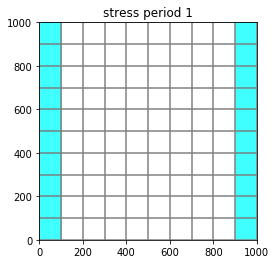

In [152]:
# Make the plots
mytimes = [1.0, 101.0, 201.0]
for iplot, time in enumerate(mytimes):
    print('*****Processing time: ', time)
    head = headobj.get_data(totim=time)
    #Print statistics
    print('Head statistics')
    print('  min: ', head.min())
    print('  max: ', head.max())
    print('  std: ', head.std())

    # Extract flow right face and flow front face
    frf = cbb.get_data(text='FLOW RIGHT FACE', totim=time)[0]
    fff = cbb.get_data(text='FLOW FRONT FACE', totim=time)[0]

    #Create the plot
    #plt.subplot(1, len(mytimes), iplot + 1, aspect='equal')
    plt.subplot(1, 1, 1, aspect='equal')
    plt.title('stress period ' + str(iplot + 1))


    modelmap = flopy.plot.ModelMap(model=mf, layer=0)
    qm = modelmap.plot_ibound()
    lc = modelmap.plot_grid()
    qm = modelmap.plot_bc('GHB', alpha=0.5)
    cs = modelmap.contour_array(head, levels=levels)
    plt.clabel(cs, inline=1, fontsize=10, fmt='%1.1f', zorder=11)
    quiver = modelmap.plot_discharge(frf, fff, head=head)


    mfc = 'None'
    if (iplot+1) == len(mytimes):
        mfc='black'
    plt.plot(wpt[0], wpt[1], lw=0, marker='o', markersize=8, 
             markeredgewidth=0.5,
             markeredgecolor='black', markerfacecolor=mfc, zorder=9)
    plt.text(wpt[0]+25, wpt[1]-25, 'well', size=12, zorder=12)
    plt.savefig('tutorial2-{}.png'.format(iplot))

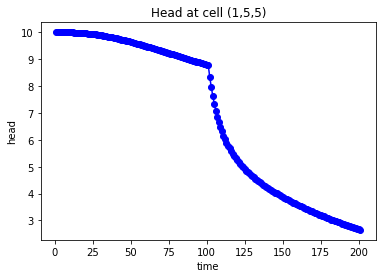

In [153]:
# Plot the head versus time
idx = (0, int(nrow/2) - 1, int(ncol/2) - 1)
ts = headobj.get_ts(idx)
plt.subplot(1, 1, 1)
ttl = 'Head at cell ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1)
plt.title(ttl)
plt.xlabel('time')
plt.ylabel('head')
plt.plot(ts[:, 0], ts[:, 1], 'bo-')
plt.savefig(wspath+'tutorial2-ts.png')